In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ezyqu798
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ezyqu798
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=a602a73197b172649242265d9bd87e46f84a1ef292559c6edadb8c50d40f1c54
  Stored in directory: /tmp/pip-ephem-wheel-cache-xzu9enw8/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

print(AUTOTUNE)

-1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  # Remove the batch dimension
  image = tf.squeeze(image, axis=0)

  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  # Add the batch dimension back
  cropped_image = tf.expand_dims(cropped_image, axis=0)

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # Ensure the image has 3 color channels (RGB)
  if image.shape[-1] != 3:
    image = tf.image.grayscale_to_rgb(image)

  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
def load_custom_dataset(data_dir, image_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE):
    """
    Load a custom dataset from specified directories and apply preprocessing steps.

    Args:
        data_dir (str): The root directory containing 'trainA', 'trainB', 'testA', and 'testB' folders.
        image_size (tuple): The size to resize the images to, e.g., (256, 256).
        batch_size (int): The batch size for the dataset.
        buffer_size (int): The buffer size for shuffling.

    Returns:
        train_horses (tf.data.Dataset): Dataset for 'trainA' images.
        train_zebras (tf.data.Dataset): Dataset for 'trainB' images.
        test_horses (tf.data.Dataset): Dataset for 'testA' images.
        test_zebras (tf.data.Dataset): Dataset for 'testB' images.
    """
    # Define data directories
    trainA_dir = os.path.join(data_dir, 'trainA')
    trainB_dir = os.path.join(data_dir, 'trainB')
    testA_dir = os.path.join(data_dir, 'testA')
    testB_dir = os.path.join(data_dir, 'testB')

    # Define image preprocessing functions (preprocess_image_train and preprocess_image_test)
    # Make sure to define these functions according to your specific requirements.


    train_ct = tf.keras.utils.image_dataset_from_directory(
        trainA_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    ).cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

    train_mri = tf.keras.utils.image_dataset_from_directory(
        trainB_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    ).cache().map(preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(buffer_size).batch(batch_size)

    test_ct = tf.keras.utils.image_dataset_from_directory(
        testA_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
    ).map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

    test_mri = tf.keras.utils.image_dataset_from_directory(
        testB_dir,
        label_mode=None,
        image_size=image_size,
        batch_size=batch_size,
    ).map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

    return train_ct, train_mri, test_ct, test_mri


In [ ]:
data_dir='/content/drive/MyDrive/Colab_Notebooks/Cyclegan/ct_mri_dataset/images'
train_ct, train_mri, test_ct, test_mri=load_custom_dataset(data_dir)

Found 1742 files belonging to 1 classes.
Found 1744 files belonging to 1 classes.
Found 744 files belonging to 1 classes.
Found 744 files belonging to 1 classes.


In [ ]:
def remove_batch_dimension(image):
    # Remove the first dimension
    return image[0]

In [ ]:
train_ct = train_ct.map(remove_batch_dimension)
train_mri = train_mri.map(remove_batch_dimension)
test_ct = test_ct.map(remove_batch_dimension)
test_mri = test_mri.map(remove_batch_dimension)

In [ ]:
sample_ct = next(iter(train_ct))
sample_mri = next(iter(train_mri))
# sample_ct_jittered=sample_ct[0]
# sample_mri_jittered=sample_mri[0]

In [ ]:
sample_ct.shape

TensorShape([1, 256, 256, 3])

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

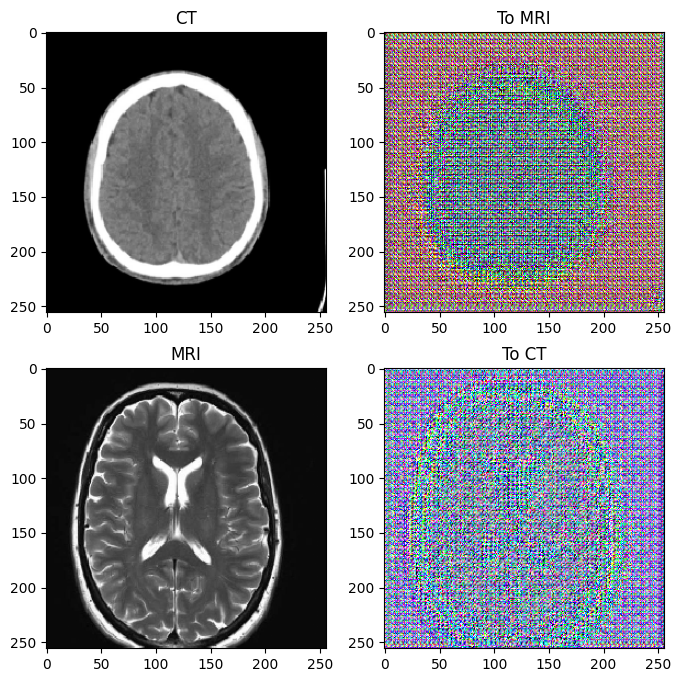

In [ ]:
to_mri = generator_g(sample_ct)
to_ct = generator_f(sample_mri)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_ct, to_mri, sample_mri, to_ct]
title = ['CT', 'To MRI', 'MRI', 'To CT']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
# plt.figure(figsize=(8, 8))

# plt.subplot(121)
# plt.title('Is a real MRI?')
# plt.imshow(discriminator_y(sample_mri)[0, ..., -1], cmap='RdBu_r')

# plt.subplot(122)
# plt.title('Is a real CT?')
# plt.imshow(discriminator_x(sample_ct)[0, ..., -1], cmap='RdBu_r')

# plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/Cyclegan/Runtime/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 50

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


In [ ]:
from tqdm import tqdm

# MSE loss function
def mse_loss(target, predicted):
    return tf.reduce_mean(tf.square(target - predicted))

# Model training
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    mse_loss_values = []  # To store MSE loss values for each iteration

    progress_bar = tqdm(tf.data.Dataset.zip((train_ct, train_mri)), desc=f'Epoch {epoch + 1}', total=len(train_ct))

    for image_x, image_y in progress_bar:
        train_step(image_x, image_y)
        mse_loss_value = mse_loss(image_y, generator_f(image_x))
        mse_loss_values.append(mse_loss_value.numpy())

        if n % 10 == 0:
            progress_bar.set_postfix({'Elapsed Time': time.time() - start, 'MSE Loss': mse_loss_value.numpy()})
        n += 1

    clear_output(wait=True)

    generate_images(generator_f, sample_ct)

    # Calculate and print the mean MSE loss for the epoch
    mean_mse_loss = sum(mse_loss_values) / len(mse_loss_values)
    print(f'Mean MSE Loss for Epoch {epoch + 1}: {mean_mse_loss}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))


In [ ]:
# Model Prediction: Generate MRI images for given CT images
for ct_image in test_ct.take(5):
    # Generate MRI image from CT using generator_f
    generated_mri = generator_f(ct_image, training=False)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original CT')
    plt.imshow((ct_image[0] + 1) / 2.0)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated MRI')
    plt.imshow((generated_mri[0] + 1) / 2.0)
    plt.axis('off')

    plt.show()
